In [181]:
# pip install "textdistance[extras]"
import pandas as pd
import json
import re
import numpy as np
import random as rd
from random import seed
from random import randint
from random import choices
import itertools
import textdistance
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
import math
import re
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
## Several small defintions used in model

In [2]:
## Used to generate the random variables for the hash functions
def create_hash_var(num: int): 
    for i in range(0, num):
        xvar = rd.sample(range(1, num+2),num)
        yvar = rd.sample(range(0,num+2),num)
    return (xvar, yvar)

## Both used to calculate the cosine similarity, obtained from:
## https://gist.github.com/TamilvananP/002c6532cc3351a55321b5757aa4fcb1
def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    WORD = re.compile(r"\w+")
    words = WORD.findall(text)
    return Counter(words)

In [ ]:
## Open and read data

In [ ]:
with open('TVs-all-merged.json') as f:
    data = json.load(f)

amount_of_descriptions = 0
for key in data.keys():
    amount_of_descriptions += len(data[key])

new_data = {}
i = 1
for key in data.keys():
    for description in data[key]:
        new_data[i] = description
        i+=1

In [ ]:
## Create the title list

In [4]:
result = []
for i in range(1, len(new_data)+1):
     result.append(new_data[i]["title"])
result

['Philips 4000 Series 29" Class 2812" Diag. LED 720p 60Hz HDTV 29PFL4508F7 - Best Buy',
 'Newegg.com - SuperSonic 32" 720p LED HDTV SC-3211',
 'Sharp AQUOS 90" Class 90" Diag. LED 1080p 120Hz Smart 3D HDTV LC-90LE657U - Best Buy',
 'Philips 2000 Series 39" Class 3858" Diag. LED 1080p 60Hz Smart HDTV 39PFL2908F7 - Best Buy',
 'Newegg.com - Sharp Aquos 70" Class (69.5" Diagonal) 1080p 120Hz LED-LCD HDTV - LC70LE550U',
 'Newegg.com - Refurbished: Samsung 40" 1080p 120Hz Smart LED HDTV - UN40F6350A',
 'Samsung 40" Class 40" Diag. LEDLCD TV 1080p HDTV 1080p HG40NA577LF - Best Buy',
 'Samsung 46" Class 46" Diag. LEDLCD TV 1080p HDTV 1080p Rose Black UN46F5000AF - Best Buy',
 'NEC Refurbished 46" Class 46" Diag. LEDLCD TV 1080p HDTV 1080p E463 - Best Buy',
 'Samsung UN46ES6580 46-Inch 1080p 120Hz 3D Slim LED HDTV (Black)',
 'Newegg.com - Refurbished: Samsung 46" Class (45.9" Diag.) 1080p 240Hz LED HDTV UN46ES6580',
 'TCL 39" Class 3812" Diag. LED 1080p 60Hz HDTV LE39FHDE3010 - Best Buy',
 'To

In [ ]:
## Create the different sets for the 5 bootstraps

In [19]:
bootstraplist = []
numofbootstraps = 5
train = []
test = []
for i in range(0, numofbootstraps):
    bootstrap = rd.choices(range(0,len(result)),k=len(result))
    bootstrapnodup = list(dict.fromkeys(bootstrap))
    fulllist = list(range(0, len(result)))
    train.append(sorted(bootstrapnodup))
    testlist = (list(set(fulllist) - set(train[i])))
    test.append(testlist)

In [ ]:
## LSH model for first duplicate matrix

In [130]:
def full_model_LSH(train, modelID, modvar):

    splittedstring = []
    for i in train:
        splittedstring.append(result[i].split())
    splittedstring

    modelIDtrain = []
    for i in train:
        modelIDtrain.append(modelID[i])
    modelIDtrain

    testfase = splittedstring

    modelwords = []
    for i in range(0, len(testfase)):
        for j in range(0, len(testfase[i])):
            testfase[i][j] = testfase[i][j].replace('-Inch','"')
            testfase[i][j] = testfase[i][j].replace('-inch','"')
            testfase[i][j] = testfase[i][j].replace('inch','"')
            testfase[i][j] = testfase[i][j].replace(' Hz', 'Hz')
            testfase[i][j] = testfase[i][j].replace(' hz', 'Hz')
            testfase[i][j] = testfase[i][j].replace('hz', 'Hz')
            testfase[i][j] = testfase[i][j].replace('hertz', 'Hz')
            testfase[i][j] = testfase[i][j].replace('-hz', 'Hz')
            testfase[i][j] = testfase[i][j].replace('HZ', 'Hz')
            
    import re
    thesum = 0
    regex = re.compile('\'[@_!#$%^&*<>?/\|}{~]\"')
    for i in range(0, len(testfase)):
        for j in range(0, len(testfase[i])):
            if bool(regex.search(testfase[i][j])):
                thesum = thesum + 1
            if bool(re.match('[a-zA-Z0-9]', testfase[i][j])):
                thesum = thesum + 1
            if bool(re.search("[0-9]", testfase[i][j])):
                thesum = thesum + 1
            if thesum >= 2:
                modelwords.append(testfase[i][j])
            thesum = 0

    regex = re.compile(r'.{3,}"')
    modelwordslsh_final = []
    modelwordslsh = [g for g in modelwords if not regex.match(g)]
    modelwordslsh_final.append(modelwordslsh)
    modelwordscorrect = modelwordslsh_final[0]

    mylist = list(dict.fromkeys(modelwordscorrect))

    s = (len(mylist),len(modelIDtrain))
    A = np.zeros(s)
    df = pd.DataFrame(A, index=mylist, columns=modelIDtrain)

    testfase2 = testfase
    for i in range(0, len(testfase2)):
        for j in range(0, len(testfase2[i])):
            testfase2[i][j] = testfase2[i][j].replace('#','"')
            testfase2[i][j] = testfase2[i][j].replace('-Inch','"')
            testfase2[i][j] = testfase2[i][j].replace('-inch','"')
            testfase2[i][j] = testfase2[i][j].replace(' inch','"')
            testfase2[i][j] = testfase2[i][j].replace(' Hz', 'Hz')
            testfase2[i][j] = testfase2[i][j].replace(' hz', 'Hz')
            testfase2[i][j] = testfase2[i][j].replace('hz', 'Hz')
            testfase2[i][j] = testfase2[i][j].replace('hertz', 'Hz')
            testfase2[i][j] = testfase2[i][j].replace('-hz', 'Hz')
            testfase2[i][j] = testfase2[i][j].replace('HZ', 'Hz')
    testfase2

    s = (len(mylist),len(modelIDtrain))
    At = np.zeros(s)
    df2 = pd.DataFrame(At, index=mylist, columns=modelIDtrain)
    for z in range(0, len(modelIDtrain)):
        for j in range(0, len(testfase2[z])):
            for i in range(0, len(mylist)):
                if testfase2[z][j] == mylist[i]:
                    df2.iloc[i,z]= 1

    seed(0)
    xvar = []
    yvar =[]
    num_of_hashes = int(len(mylist)/2)-int(len(mylist)/2)%modvar
    primes = []
    for number in range(num_of_hashes,800):  
        if number > 1:  
            for i in range(2,number):  
                if (number % i) == 0:  
                    break  
            else:  
                primes.append(number)
       
    randomprime = rd.sample(primes, 1)
    mod = randomprime[0]
    variables = create_hash_var(num_of_hashes)
    hashvalue = [ [ 0 for i in range(len(df2)) ] for j in range(num_of_hashes) ]
    for j in range(1, num_of_hashes+1):
        for i in range(1,len(df2)):
            hashvalue[j-1][i-1] = ((variables[0][j-1]*i+variables[1][j-1])%mod)
    final = hashvalue

    transposedf2 = df2.transpose()

    sig = [float('inf')]*num_of_hashes
    signatures = [sig]*(len(transposedf2))
    signaturesdf = pd.DataFrame(signatures, index = [modelIDtrain])
    signaturesdf.columns = np.arange(1,num_of_hashes+1)

    for i in range(0,len(transposedf2)): ## i is for the rows (modelID)
        for j in range(0, len(transposedf2.iloc[0])): ## j is for the columns (model words)
            if transposedf2.iloc[i,j] == 1: ## check for the first tv, than for the model words if it is present
                for z in range(0, len(final)): ## check for the different hashes
                    if final[z][j] < signaturesdf.iloc[i,z]: ## if value per hash, per e
                        signaturesdf.iloc[i,z] = final[z][j]                    

    signaturesdft = signaturesdf.transpose()

    bandlength = modvar
    amountofbandths = num_of_hashes/bandlength
    signaturesperbandth = [];
    for i in range(1, int(amountofbandths)+1):
            if i == 1:
                signaturesperbandth.append(signaturesdft.iloc[0:bandlength].astype(int))
            else:
                signaturesperbandth.append(signaturesdft.iloc[bandlength*(i-1):bandlength*(i)].astype(int))

    matrixwithkeyssize = (len(signaturesperbandth),len(modelIDtrain))
    matrixwithkeys = np.zeros(matrixwithkeyssize)
    allkeys = pd.DataFrame(matrixwithkeys, columns=modelIDtrain)

    string = ''
    for b in range(0, len(signaturesperbandth)):
        for j in range(0, len(signaturesperbandth[b].iloc[0])):
            for i in range(0, len(signaturesperbandth[0])):
                string = string + str(signaturesperbandth[b].iloc[i,j])
            allkeys.iloc[b,j] = string
            string = ''

    tvlist = ["tv" + str(i) for i in train]

    sizekeys = (len(allkeys.iloc[0]),len(allkeys))
    sizething = np.zeros(sizekeys)
    allkeyspertv = pd.DataFrame(sizething, index=modelIDtrain)

    tvlength = (len(tvlist),len(tvlist))
    Atvlength = np.zeros(tvlength)
    dftvlist = pd.DataFrame(Atvlength, index=tvlist, columns=tvlist)
    dftvlistint = dftvlist.astype(int)

    for i in range(0, len(allkeys)):
        allkeysperband = pd.DataFrame(allkeys.iloc[i,:])
        allkeysperband.reset_index(drop=True)
        allkeysperband.index = tvlist
        sortedkeypertv = allkeysperband.sort_values(i)

        masterlist = [];
        smallerlist = [];
        for j in range(0, len(sortedkeypertv)-1):
            if j == (len(sortedkeypertv)-2):
                smallerlist.append(str(sortedkeypertv.index[j]))
                smallerlist.append(str(sortedkeypertv.index[j+1]))
                masterlist.append(smallerlist)
            elif sortedkeypertv[i][j+1] == sortedkeypertv[i][j]:
                smallerlist.append(str(sortedkeypertv.index[j]))
            else:
                smallerlist.append(str(sortedkeypertv.index[j]))
                masterlist.append(smallerlist)
                smallerlist = []

        listofcombos = []
        for z in range(0, len(masterlist)):
            for subset in itertools.combinations(masterlist[z], 2):
                listofcombos.append(subset)

        for p in range(0,len(listofcombos)):
            dftvlistint[listofcombos[p][0]][listofcombos[p][1]] = 1
            dftvlistint[listofcombos[p][1]][listofcombos[p][0]] = 1
    
    ## Now LSH is finished
    arrdata = dftvlistint.to_numpy()
    newarrdata = np.triu(arrdata)
    dfnew = pd.DataFrame(newarrdata)
    
    #All comparisons made from candidate pairs
    numofcomp2 = dfnew
    numofcomp2 = numofcomp2.replace(float('-inf'),0)
    numberofcomparisons2 = sum(numofcomp2[numofcomp2 > 0].count())
    
    ## All comparisons possible
    onematrixl = (len(dftvlistint), len(dftvlistint))
    onematrix = np.ones(onematrixl)
    onematrixup = np.triu(onematrix)
    np.fill_diagonal(onematrixup, 0)
    onematrixupdf = pd.DataFrame(onematrixup)
    numofonesindf = sum(onematrixupdf[onematrixupdf > 0].count())
    
    fracofcomparisons = numberofcomparisons2/numofonesindf
    
    modelwordsperlist = []
    for i in range(0, len(testfase)):
        for j in range(0, len(testfase[i])):
            if bool(regex.search(testfase[i][j])):
                thesum = thesum + 1
            if bool(re.match('[a-zA-Z0-9]', testfase[i][j])):
                thesum = thesum + 1
            if bool(re.search("[0-9]", testfase[i][j])):
                thesum = thesum + 1
            if thesum >= 2:
                modelwordsperlist.append(testfase[i][j])
            thesum = 0
        modelwords.insert(i,modelwordsperlist)
        modelwordsperlist = []

    regex = re.compile(r'.{3,}"')
    modelwordscleaned_final = []
    for i in range(0, len(modelwords)):
        modelwordsclean = [g for g in modelwords[i] if not regex.match(g)]
        modelwordscleaned_final.append(modelwordsclean)
    
    shops = []
    for i in train:
         shops.append(new_data[i+1]["shop"])
    
    brands = []
    for i in train:
        if ('Brand' in new_data[i+1]['featuresMap']):
            brands.append(new_data[i+1]['featuresMap']['Brand'])
        elif ('Brand Name' in new_data[i+1]['featuresMap']):
            brands.append(new_data[i+1]['featuresMap']['Brand Name'])
        else:
            brands.append('No brand')

    tvlength = (len(tvlist),len(tvlist))
    Atvlength = np.zeros(tvlength)
    dftvlist = pd.DataFrame(Atvlength, index=tvlist, columns=tvlist )
    dftvlist
    
    modelID_current = []
    for i in train:
        modelID_current.append(new_data[i+1]["title"])

    for i in range(0, len(train)):
        for j in range(0, len(train)):
            if j > i:
                if dfnew.iloc[i,j] == 1:
                    dftvlist.iloc[i,j] = get_cosine(text_to_vector(modelID_current[i]), text_to_vector(modelID_current[j]))
    
    for i in range(0, len(dftvlist)):
        for j in range(0, len(dftvlist)):
            if j > i and shops[i] == shops[j]:
                dftvlist.iloc[i,j] = -float('inf')
            if j > i and brands[i] != brands[j] and brands[i] != 'No brand' and brands[j] != 'No brand':
                dftvlist.iloc[i,j] = -float('inf')
                
    ## All comparisons, with shops and brands taken into account with LSH
    numofcomp = dftvlist
    numofcomp = numofcomp.replace(float('-inf'),0)
    numberofcomparisons = sum(numofcomp[numofcomp > 0].count())
    
    ## All possible comparisons, with shops and brands taken into account
    onematrix2 = (len(dftvlistint), len(dftvlistint))
    onematrix3 = np.ones(onematrix2)
    onematrixup2 = np.triu(onematrix3)
    np.fill_diagonal(onematrixup2, 0)
    onematrixupdf2 = pd.DataFrame(onematrixup2)
    for i in range(0, len(onematrixupdf2)):
        for j in range(0, len(onematrixupdf2)):
            if j > i and shops[i] == shops[j]:
                onematrixupdf2.iloc[i,j] = 0
            if j > i and brands[i] != brands[j] and brands[i] != 'No brand' and brands[j] != 'No brand':
                onematrixupdf2.iloc[i,j] = 0
    numofonesindf4 = sum(onematrixupdf[onematrixupdf2 > 0].count())
    
    fracofcomparisons2 = numberofcomparisons/numofonesindf4
    
    originalm = (len(modelIDtrain),len(modelIDtrain))
    originalA = np.zeros(originalm)
    originalcorrect = pd.DataFrame(originalA, index=modelIDtrain, columns=modelIDtrain)
    for i in range(0, len(modelIDtrain)):
        for j in range(0, len(modelIDtrain)):
            if modelIDtrain[i] == modelIDtrain[j]:
                originalcorrect.iloc[i,j] = 1
    originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0

    falsenegativesLSH = 0
    falsepositivesLSH = 0
    truenegativesLSH = 0
    truepositivesLSH = 0

    for i in range(0, len(originalcorrect)):
        for j in range(0, len(originalcorrect)):
            if j > i:
                if  dfnew.iloc[i,j] == 0 and originalcorrect.iloc[i,j] == 0:
                    truenegativesLSH = truenegativesLSH + 1
                elif  dfnew.iloc[i,j] == 0 and originalcorrect.iloc[i,j] == 1:
                    falsenegativesLSH = falsenegativesLSH + 1
                elif  dfnew.iloc[i,j] == 1 and originalcorrect.iloc[i,j] == 0:
                    falsepositivesLSH = falsepositivesLSH + 1
                elif  dfnew.iloc[i,j] == 1 and originalcorrect.iloc[i,j] == 1:
                    truepositivesLSH = truepositivesLSH + 1

    f1measureLSH = (truepositivesLSH/(truepositivesLSH+0.5*(falsenegativesLSH+falsepositivesLSH)))
    pairqualityLSH = (truepositivesLSH)/(numberofcomparisons) 
    paircompletenessLSH = (truepositivesLSH)/(truepositivesLSH + falsenegativesLSH)
    f1starmeasureLSH = (2*pairqualityLSH*paircompletenessLSH)/(pairqualityLSH+paircompletenessLSH)
    
    return (fracofcomparisons, fracofcomparisons2, f1starmeasureLSH, f1measureLSH, truepositivesLSH, falsepositivesLSH, falsenegativesLSH, truenegativesLSH, pairqualityLSH, paircompletenessLSH)

In [ ]:
## Creating the graphs

In [138]:
outcomes = []
points = [1, 3 , 4, 5, 7, 10, 14]
for i in points:
    for j in range(0, 5):
        outcome_tuple = full_model_LSH(test[j], modelID, i)
        outcomes.append(outcome_tuple)
print(i)

<ipython-input-130-e322e34e1407>:288: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-130-e322e34e1407>:288: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-130-e322e34e1407>:288: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arra

<ipython-input-130-e322e34e1407>:288: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-130-e322e34e1407>:288: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-130-e322e34e1407>:288: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arra

14


In [177]:
avg_f1star = []
avg_fracofcomp =[]
avg_paircomplete = []
avg_pairqual= []
currentavgf1star = 0
currentfracofcomp = 0
currentpaircomp = 0
currentpairqual = 0
iterations = [0,5,10,15,20,25,30]
for i in iterations:
    currentavgf1star = outcomes[i][2]+outcomes[i+1][2]+outcomes[i+2][2]+outcomes[i+3][2]+outcomes[i+4][2]
    avg_f1star.append(currentavgf1star/5)
    
    currentfracofcomp = outcomes[i][0]+outcomes[i+1][0]+outcomes[i+2][0]+outcomes[i+3][0]+outcomes[i+4][0]
    avg_fracofcomp.append(currentfracofcomp/5)
    
    currentpaircomp = outcomes[i][9]+outcomes[i+1][9]+outcomes[i+2][9]+outcomes[i+3][9]+outcomes[i+4][9]
    avg_paircomplete.append(currentpaircomp/5)
    
    currentpairqual = outcomes[i][8]+outcomes[i+1][8]+outcomes[i+2][8]+outcomes[i+3][8]+outcomes[i+4][8]
    avg_pairqual.append(currentpairqual/5)

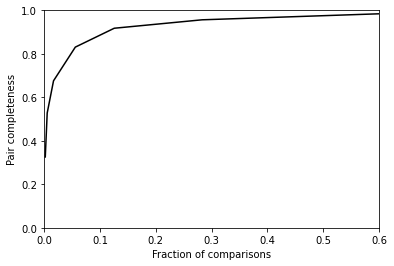

In [320]:
plt.plot(avg_fracofcomp, avg_paircomplete, 'k')
plt.xlim(0,0.6)
plt.ylim(0,1)
plt.xlabel('Fraction of comparisons')
plt.ylabel('Pair completeness')
plt.savefig('fig1.png')

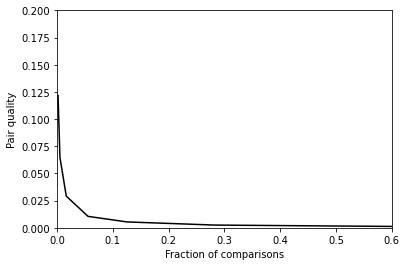

In [314]:
plt.plot(avg_fracofcomp, avg_pairqual, 'k')
plt.xlim(0,0.6)
plt.ylim(0,0.2)
plt.xlabel('Fraction of comparisons')
plt.ylabel('Pair quality')
plt.savefig('fig2.png')

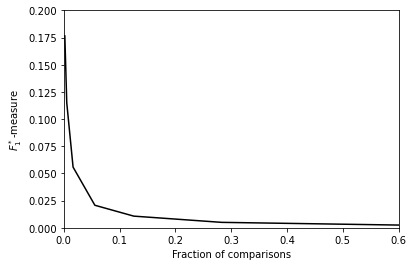

In [319]:
plt.plot(avg_fracofcomp, avg_f1star, 'k')
plt.xlim(0,0.6)
plt.ylim(0,0.2)
plt.xlabel('Fraction of comparisons')
plt.ylabel('$F_{1}^*$-measure')
plt.savefig('fig3.png')

In [ ]:
## Creating the full model including the Title Model Words Method

In [280]:
def full_model(train, beta, delta, gamma, modelID, modvar,param_cluster):
    
    splittedstring = []
    for i in train:
        splittedstring.append(result[i].split())
    splittedstring

    modelIDtrain = []
    for i in train:
        modelIDtrain.append(modelID[i])
    modelIDtrain

    testfase = splittedstring
    
    ## Cleaning the data
    modelwords = []
    for i in range(0, len(testfase)):
        for j in range(0, len(testfase[i])):
            testfase[i][j] = testfase[i][j].replace('-Inch','"')
            testfase[i][j] = testfase[i][j].replace('-inch','"')
            testfase[i][j] = testfase[i][j].replace('inch','"')
            testfase[i][j] = testfase[i][j].replace(' Hz', 'Hz')
            testfase[i][j] = testfase[i][j].replace(' hz', 'Hz')
            testfase[i][j] = testfase[i][j].replace('hz', 'Hz')
            testfase[i][j] = testfase[i][j].replace('hertz', 'Hz')
            testfase[i][j] = testfase[i][j].replace('-hz', 'Hz')
            testfase[i][j] = testfase[i][j].replace('HZ', 'Hz')
    import re
    thesum = 0
    regex = re.compile('\'[@_!#$%^&*<>?/\|}{~]\"')
    for i in range(0, len(testfase)):
        for j in range(0, len(testfase[i])):
            if bool(regex.search(testfase[i][j])):
                thesum = thesum + 1
            if bool(re.match('[a-zA-Z0-9]', testfase[i][j])):
                thesum = thesum + 1
            if bool(re.search("[0-9]", testfase[i][j])):
                thesum = thesum + 1
            if thesum >= 2:
                modelwords.append(testfase[i][j])
            thesum = 0

    regex = re.compile(r'.{3,}"')
    modelwordslsh_final = []
    modelwordslsh = [g for g in modelwords if not regex.match(g)]
    modelwordslsh_final.append(modelwordslsh)
    modelwordscorrect = modelwordslsh_final[0]

    mylist = list(dict.fromkeys(modelwordscorrect))

    s = (len(mylist),len(modelIDtrain))
    A = np.zeros(s)
    df = pd.DataFrame(A, index=mylist, columns=modelIDtrain)

    testfase2 = testfase
    for i in range(0, len(testfase2)):
        for j in range(0, len(testfase2[i])):
            testfase2[i][j] = testfase2[i][j].replace('#','"')
            testfase2[i][j] = testfase2[i][j].replace('-Inch','"')
            testfase2[i][j] = testfase2[i][j].replace('-inch','"')
            testfase2[i][j] = testfase2[i][j].replace(' inch','"')
            testfase2[i][j] = testfase2[i][j].replace(' Hz', 'Hz')
            testfase2[i][j] = testfase2[i][j].replace(' hz', 'Hz')
            testfase2[i][j] = testfase2[i][j].replace('hz', 'Hz')
            testfase2[i][j] = testfase2[i][j].replace('hertz', 'Hz')
            testfase2[i][j] = testfase2[i][j].replace('-hz', 'Hz')
            testfase2[i][j] = testfase2[i][j].replace('HZ', 'Hz')
    testfase2

    s = (len(mylist),len(modelIDtrain))
    At = np.zeros(s)
    df2 = pd.DataFrame(At, index=mylist, columns=modelIDtrain)
    for z in range(0, len(modelIDtrain)):
        for j in range(0, len(testfase2[z])):
            for i in range(0, len(mylist)):
                if testfase2[z][j] == mylist[i]:
                    df2.iloc[i,z]= 1
                                   
    ## Creating the random hashes
    seed(0)
    xvar = []
    yvar =[]
    num_of_hashes = int(len(mylist)/2)-int(len(mylist)/2)%modvar
    primes = []
    for number in range(num_of_hashes,800):  
        if number > 1:  
            for i in range(2,number):  
                if (number % i) == 0:  
                    break  
            else:  
                primes.append(number)
       
    randomprime = rd.sample(primes, 1)
    mod = randomprime[0]
    variables = create_hash_var(num_of_hashes)
    hashvalue = [ [ 0 for i in range(len(df2)) ] for j in range(num_of_hashes) ]
    for j in range(1, num_of_hashes+1):
        for i in range(1,len(df2)):
            hashvalue[j-1][i-1] = ((variables[0][j-1]*i+variables[1][j-1])%mod)
    final = hashvalue

    transposedf2 = df2.transpose()
    
    ## Creating the signatures
    sig = [float('inf')]*num_of_hashes
    signatures = [sig]*(len(transposedf2))
    signaturesdf = pd.DataFrame(signatures, index = [modelIDtrain])
    signaturesdf.columns = np.arange(1,num_of_hashes+1)

    for i in range(0,len(transposedf2)): ## i is for the rows (modelID)
        for j in range(0, len(transposedf2.iloc[0])): ## j is for the columns (model words)
            if transposedf2.iloc[i,j] == 1: ## check for the first tv, than for the model words if it is present
                for z in range(0, len(final)): ## check for the different hashes
                    if final[z][j] < signaturesdf.iloc[i,z]: ## if value per hash, per e
                        signaturesdf.iloc[i,z] = final[z][j]                    

    signaturesdft = signaturesdf.transpose()

    bandlength = modvar
    amountofbandths = num_of_hashes/bandlength
    signaturesperbandth = [];
    for i in range(1, int(amountofbandths)+1):
            if i == 1:
                signaturesperbandth.append(signaturesdft.iloc[0:bandlength].astype(int))
            else:
                signaturesperbandth.append(signaturesdft.iloc[bandlength*(i-1):bandlength*(i)].astype(int))

    matrixwithkeyssize = (len(signaturesperbandth),len(modelIDtrain))
    matrixwithkeys = np.zeros(matrixwithkeyssize)
    allkeys = pd.DataFrame(matrixwithkeys, columns=modelIDtrain)

    string = ''
    for b in range(0, len(signaturesperbandth)):
        for j in range(0, len(signaturesperbandth[b].iloc[0])):
            for i in range(0, len(signaturesperbandth[0])):
                string = string + str(signaturesperbandth[b].iloc[i,j])
            allkeys.iloc[b,j] = string
            string = ''

    tvlist = ["tv" + str(i) for i in train]

    sizekeys = (len(allkeys.iloc[0]),len(allkeys))
    sizething = np.zeros(sizekeys)
    allkeyspertv = pd.DataFrame(sizething, index=modelIDtrain)

    tvlength = (len(tvlist),len(tvlist))
    Atvlength = np.zeros(tvlength)
    dftvlist = pd.DataFrame(Atvlength, index=tvlist, columns=tvlist)
    dftvlistint = dftvlist.astype(int)
    
    ## All of the candidate duplicates are put into a matrix
    for i in range(0, len(allkeys)):
        allkeysperband = pd.DataFrame(allkeys.iloc[i,:])
        allkeysperband.reset_index(drop=True)
        allkeysperband.index = tvlist
        sortedkeypertv = allkeysperband.sort_values(i)

        masterlist = [];
        smallerlist = [];
        for j in range(0, len(sortedkeypertv)-1):
            if j == (len(sortedkeypertv)-2):
                smallerlist.append(str(sortedkeypertv.index[j]))
                smallerlist.append(str(sortedkeypertv.index[j+1]))
                masterlist.append(smallerlist)
            elif sortedkeypertv[i][j+1] == sortedkeypertv[i][j]:
                smallerlist.append(str(sortedkeypertv.index[j]))
            else:
                smallerlist.append(str(sortedkeypertv.index[j]))
                masterlist.append(smallerlist)
                smallerlist = []

        listofcombos = []
        for z in range(0, len(masterlist)):
            for subset in itertools.combinations(masterlist[z], 2):
                listofcombos.append(subset)

        for p in range(0,len(listofcombos)):
            dftvlistint[listofcombos[p][0]][listofcombos[p][1]] = 1
            dftvlistint[listofcombos[p][1]][listofcombos[p][0]] = 1
    
    arrdata = dftvlistint.to_numpy()
    newarrdata = np.triu(arrdata)
    dfnew = pd.DataFrame(newarrdata)
    
    #All comparisons made from candidate pairs
    numofcomp2 = dfnew
    numofcomp2 = numofcomp2.replace(float('-inf'),0)
    numberofcomparisons2 = sum(numofcomp2[numofcomp2 > 0].count())
    
    ## All comparisons possible
    onematrixl = (len(dftvlistint), len(dftvlistint))
    onematrix = np.ones(onematrixl)
    onematrixup = np.triu(onematrix)
    np.fill_diagonal(onematrixup, 0)
    onematrixupdf = pd.DataFrame(onematrixup)
    numofonesindf = sum(onematrixupdf[onematrixupdf > 0].count())
    
    fracofcomparisons = numberofcomparisons2/numofonesindf
    
    modelwordsperlist = []
    for i in range(0, len(testfase)):
        for j in range(0, len(testfase[i])):
            if bool(regex.search(testfase[i][j])):
                thesum = thesum + 1
            if bool(re.match('[a-zA-Z0-9]', testfase[i][j])):
                thesum = thesum + 1
            if bool(re.search("[0-9]", testfase[i][j])):
                thesum = thesum + 1
            if thesum >= 2:
                modelwordsperlist.append(testfase[i][j])
            thesum = 0
        modelwords.insert(i,modelwordsperlist)
        modelwordsperlist = []

    regex = re.compile(r'.{3,}"')
    modelwordscleaned_final = []
    for i in range(0, len(modelwords)):
        modelwordsclean = [g for g in modelwords[i] if not regex.match(g)]
        modelwordscleaned_final.append(modelwordsclean)
    
    shops = []
    for i in train:
         shops.append(new_data[i+1]["shop"])
    
    brands = []
    for i in train:
        if ('Brand' in new_data[i+1]['featuresMap']):
            brands.append(new_data[i+1]['featuresMap']['Brand'])
        elif ('Brand Name' in new_data[i+1]['featuresMap']):
            brands.append(new_data[i+1]['featuresMap']['Brand Name'])
        else:
            brands.append('No brand')

    tvlength = (len(tvlist),len(tvlist))
    Atvlength = np.zeros(tvlength)
    dftvlist = pd.DataFrame(Atvlength, index=tvlist, columns=tvlist )
    dftvlist
    
    modelID_current = []
    for i in train:
        modelID_current.append(new_data[i+1]["title"])

    for i in range(0, len(train)):
        for j in range(0, len(train)):
            if j > i:
                if dfnew.iloc[i,j] == 1:
                    dftvlist.iloc[i,j] = get_cosine(text_to_vector(modelID_current[i]), text_to_vector(modelID_current[j]))
    
    for i in range(0, len(dftvlist)):
        for j in range(0, len(dftvlist)):
            if j > i and shops[i] == shops[j]:
                dftvlist.iloc[i,j] = -float('inf')
            if j > i and brands[i] != brands[j] and brands[i] != 'No brand' and brands[j] != 'No brand':
                dftvlist.iloc[i,j] = -float('inf')
                
    ## All comparisons, with shops and brands taken into account with LSH
    numofcomp = dftvlist
    numofcomp = numofcomp.replace(float('-inf'),0)
    numberofcomparisons = sum(numofcomp[numofcomp > 0].count())
    
    ## All possible comparisons, with shops and brands taken into account
    onematrix2 = (len(dftvlistint), len(dftvlistint))
    onematrix3 = np.ones(onematrix2)
    onematrixup2 = np.triu(onematrix3)
    np.fill_diagonal(onematrixup2, 0)
    onematrixupdf2 = pd.DataFrame(onematrixup2)
    for i in range(0, len(onematrixupdf2)):
        for j in range(0, len(onematrixupdf2)):
            if j > i and shops[i] == shops[j]:
                onematrixupdf2.iloc[i,j] = 0
            if j > i and brands[i] != brands[j] and brands[i] != 'No brand' and brands[j] != 'No brand':
                onematrixupdf2.iloc[i,j] = 0
    numofonesindf4 = sum(onematrixupdf[onematrixupdf2 > 0].count())
    
    fracofcomparisons2 = numberofcomparisons/numofonesindf4
    
    tvlength = (len(tvlist),len(tvlist))
    Atvlength = np.zeros(tvlength)
    dfsimlev = pd.DataFrame(Atvlength)

    tvlength1 = (len(tvlist),len(tvlist))
    Atvlength1 = np.zeros(tvlength1)
    dfsimlevMW = pd.DataFrame(Atvlength1)

    list1=[]
    regex = re.compile(r'[0-9]*')
    for i in range(0, len(modelwordscleaned_final)):
        list2 = [re.sub(r'[0-9]*', '', item) for item in modelwordscleaned_final[i]]
        list1.append(list2)

    list3=[]
    regex = re.compile(r'[^0-9]*')
    for i in range(0, len(modelwordscleaned_final)):
        list4 = [re.sub(r'[^0-9]*', '', item) for item in modelwordscleaned_final[i]]
        list3.append(list4)

   ## Start of Title Model Words Method
    sum_lev_MW = 0
    sum_lev = 0
    sum_length = 0
    sum_length_allpairs = 0
    for i in range(0, len(dftvlist)):
        for j in range(0, len(dftvlist)):
            if j > i and dfnew.iloc[i,j] == 1 and dftvlist.iloc[i,j] < gamma and dftvlist.iloc[i,j] >= 0:
                for z in range(0, len(modelwordscleaned_final[i])):
                    for x in range(0, len(modelwordscleaned_final[j])):
                        first_model = list1[i][z]
                        second_model = list1[j][x]
                        text_distance = textdistance.levenshtein.normalized_distance(first_model, second_model)
                        first_item = modelwordscleaned_final[i][z]
                        second_item = modelwordscleaned_final[j][x]
                        total_distance = textdistance.levenshtein.normalized_distance(first_item, second_item)
                        length_allpairs = len(modelwordscleaned_final[i][z])+len(modelwordscleaned_final[j][x])
                        sum_lev = sum_lev + (1-total_distance) * length_allpairs
                        sum_length_allpairs = sum_length_allpairs + length_allpairs
                        if text_distance < 0.1:
                            first_word = list3[i][z]
                            second_word = list3[j][x]
                            numeric_distance = textdistance.levenshtein.normalized_distance(first_word, second_word)
                            if numeric_distance > 0:
                                dftvlist.iloc[i,j] = -float('inf')
                                length = len(modelwordscleaned_final[i][z])+len(modelwordscleaned_final[j][x])
                                sum_length = sum_length + length
                            else:
                                first_string = modelwordscleaned_final[i][z]
                                second_string = modelwordscleaned_final[j][x]
                                string_distance = textdistance.levenshtein.normalized_distance(first_string, second_string)
                                length = len(modelwordscleaned_final[i][z])+len(modelwordscleaned_final[j][x])
                                sum_lev_MW = sum_lev_MW + (1-string_distance) * length
                                sum_length = sum_length + length
            if dftvlist.iloc[i,j] != 0 and sum_length != 0:
                avg_lev = sum_lev / sum_length_allpairs
                avg_lev_MW = sum_lev_MW / sum_length
                dfsimlev.iloc[i,j] = beta * dftvlist.iloc[i,j] + (1-beta) * avg_lev
                dfsimlevMW.iloc[i,j] = delta * avg_lev_MW + (1-delta) * dfsimlev.iloc[i,j]
                sum_lev_MW = 0
                sum_length = 0
                sum_lev = 0
                sum_length_allpairs = 0

    for i in range(0, len(dfsimlevMW)):
        for j in range(0, len(dfsimlevMW)):
            if j > i and shops[i] == shops[j]:
                dfsimlevMW.iloc[i,j] = -float('inf')
            if j > i and brands[i] != brands[j] and brands[i] != 'No brand' and brands[j] != 'No brand':
                dfsimlevMW.iloc[i,j] = -float('inf')

    finalm = (len(dfsimlevMW),len(dfsimlevMW))
    finalA = np.ones(finalm)
    onematrix = pd.DataFrame(finalA)
    dfsimlevMWone = onematrix.sub(dfsimlevMW)
    finaldissimilaritymatrix = dfsimlevMWone.replace(1, 1000)
    finaldissimilaritymatrix2 = finaldissimilaritymatrix.replace(float('inf'), 1000)
    finaldissimilaritymatrix2numpy = finaldissimilaritymatrix2.to_numpy()
    i_lower = np.tril_indices(len(tvlist), -1)
    finaldissimilaritymatrix2numpy[i_lower] = finaldissimilaritymatrix2numpy.T[i_lower]
    dffinaldissim = pd.DataFrame(finaldissimilaritymatrix2numpy)

    clustering = AgglomerativeClustering(n_clusters = None, affinity='precomputed', linkage='complete', distance_threshold=param_cluster, compute_full_tree= True).fit(dffinaldissim)
    labelsclust = clustering.labels_

    originalm = (len(modelIDtrain),len(modelIDtrain))
    originalA = np.zeros(originalm)
    originalcorrect = pd.DataFrame(originalA, index=modelIDtrain, columns=modelIDtrain)
    for i in range(0, len(modelIDtrain)):
        for j in range(0, len(modelIDtrain)):
            if modelIDtrain[i] == modelIDtrain[j]:
                originalcorrect.iloc[i,j] = 1
    originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0

    clusterdm = (len(modelIDtrain),len(modelIDtrain))
    clusteredA = np.zeros(clusterdm)
    clusteredmat = pd.DataFrame(clusteredA, index=modelIDtrain, columns=modelIDtrain)
    check = pd.DataFrame(list(zip(labelsclust, modelIDtrain)))
    for i in range(0, len(modelIDtrain)):
        for j in range(0, len(modelIDtrain)):
            if check[0][i] == check[0][j]:
                clusteredmat.iloc[i,j] = 1
    clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0

    ## Calculating the different measures 
    falsenegatives = 0
    falsepositives = 0
    truenegatives = 0
    truepositives = 0

    for i in range(0, len(originalcorrect)):
        for j in range(0, len(originalcorrect)):
            if j > i:
                if  clusteredmat.iloc[i,j] == 0 and originalcorrect.iloc[i,j] == 0:
                    truenegatives = truenegatives + 1
                elif  clusteredmat.iloc[i,j] == 0 and originalcorrect.iloc[i,j] == 1:
                    falsenegatives = falsenegatives + 1
                elif  clusteredmat.iloc[i,j] == 1 and originalcorrect.iloc[i,j] == 0:
                    falsepositives = falsepositives + 1
                elif  clusteredmat.iloc[i,j] == 1 and originalcorrect.iloc[i,j] == 1:
                    truepositives = truepositives + 1

    f1measure = (truepositives/(truepositives+0.5*(falsenegatives+falsepositives)))
    pairquality = (truepositives+falsepositives)/(numberofcomparisons) 
    paircompleteness = (truepositives)/(truepositives + falsenegatives)
#     f1starmeasure = (2*pairquality*paircompleteness)/(pairquality+paircompleteness)
#     f1starmeasure remvoed
    return (fracofcomparisons, fracofcomparisons2, f1measure, truepositives, falsepositives, falsenegatives, truenegatives, pairquality, paircompleteness)

In [ ]:
## Performing the random grid search and making the final graph

In [271]:
beta =  [0.2, 0.3, 0.4]
gamma = [0.8, 0.9]
delta = [0.7, 0.8, 0.9]
candidate_thresh = [0.15, 0.18, 0.2]
modvar =  [1, 3 , 4, 5, 7, 14] 
a = [beta, gamma, delta, candidate_thresh]
f1starlist = []
f1list = []
testvariables = []
volgorde = rd.sample(list(itertools.product(*a)), 20)

In [331]:
%%time

beta =  [0.2, 0.3, 0.4]
gamma = [0.8, 0.9]
delta = [0.7, 0.8, 0.9]
candidate_thresh = [0.15, 0.18, 0.2]
# modvar =  [1, 3 , 4, 5, 7, 14] 
modvar = 14
a = [beta, gamma, delta, candidate_thresh]
f1list_fig4_14 = []
fracofcomp1_fig4_14 = []
fracofcomp2_fig4_14= []
volgorde = rd.sample(list(itertools.product(*a)), 20)

for j in range(0, 5):
    for i in range(0, len(volgorde)):
        print(i, "beta:" + str(volgorde[i][0]), "gamma:" + str(volgorde[i][1]), "delta:" + str(volgorde[i][2]), "Threshold:"+str(volgorde[i][3]),"Modvar:" + str(modvar))
        newit = full_model(train[j], volgorde[i][0], volgorde[i][1], volgorde[i][2], modelID, modvar, volgorde[i][3])

        newfracofcomp1_fig14 = newit[0]
        newfracofcomp2_fig14 = newit[1]
        newitf1 = newit[2]
        f1list_fig4_5.append(newitf1)
        fracofcomp1_fig4_14.append(newfracofcomp1_fig14)
        fracofcomp2_fig4_14.append(newfracofcomp2_fig14)
        print(newit) 

0 beta:0.4 gamma:0.9 delta:0.8 Threshold:0.2 Modvar:14


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


(0.0027497161769516444, 0.0033582464113304316, 0.30564784053156147, 46, 102, 107, 519435, 0.20108695652173914, 0.3006535947712418)
1 beta:0.2 gamma:0.9 delta:0.8 Threshold:0.2 Modvar:14


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


(0.0027497161769516444, 0.0033582464113304316, 0.3277591973244147, 49, 97, 104, 519440, 0.1983695652173913, 0.3202614379084967)
2 beta:0.4 gamma:0.8 delta:0.7 Threshold:0.2 Modvar:14


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


(0.0027497161769516444, 0.0033582464113304316, 0.2760942760942761, 41, 103, 112, 519434, 0.1956521739130435, 0.2679738562091503)
3 beta:0.2 gamma:0.8 delta:0.8 Threshold:0.18 Modvar:14


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


(0.0027497161769516444, 0.0033582464113304316, 0.3277591973244147, 49, 97, 104, 519440, 0.1983695652173913, 0.3202614379084967)
4 beta:0.3 gamma:0.9 delta:0.8 Threshold:0.18 Modvar:14


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


(0.0027497161769516444, 0.0033582464113304316, 0.31438127090301005, 47, 99, 106, 519438, 0.1983695652173913, 0.30718954248366015)
0 beta:0.4 gamma:0.9 delta:0.8 Threshold:0.2 Modvar:14


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


(0.003139407536476157, 0.003516317063604766, 0.3288590604026846, 49, 96, 104, 526602, 0.1858974358974359, 0.3202614379084967)
1 beta:0.2 gamma:0.9 delta:0.8 Threshold:0.2 Modvar:14


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


(0.003139407536476157, 0.003516317063604766, 0.32558139534883723, 49, 99, 104, 526599, 0.18974358974358974, 0.3202614379084967)
2 beta:0.4 gamma:0.8 delta:0.7 Threshold:0.2 Modvar:14


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


(0.003139407536476157, 0.003516317063604766, 0.24489795918367346, 36, 105, 117, 526593, 0.18076923076923077, 0.23529411764705882)
3 beta:0.2 gamma:0.8 delta:0.8 Threshold:0.18 Modvar:14


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


(0.003139407536476157, 0.003516317063604766, 0.32558139534883723, 49, 99, 104, 526599, 0.18974358974358974, 0.3202614379084967)
4 beta:0.3 gamma:0.9 delta:0.8 Threshold:0.18 Modvar:14


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


(0.003139407536476157, 0.003516317063604766, 0.31893687707641194, 48, 100, 105, 526598, 0.18974358974358974, 0.3137254901960784)
CPU times: user 27min 4s, sys: 4.15 s, total: 27min 8s
Wall time: 27min 6s


In [348]:
%%time
outcomes1 = []
for j in range(0, 5):
    outcome1_tuple = full_model(test[j],0.2,0.9,0.8, modelID, 1, 0.18)
    outcomes1.append(outcome1_tuple)
    print(j)

<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


0


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


1


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


2


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


3


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


4
CPU times: user 35min 42s, sys: 6.15 s, total: 35min 49s
Wall time: 35min 48s


In [333]:
%%time
outcomes = []
for j in range(0, 5):
    outcome_tuple = full_model(test[j],0.2,0.9,0.9, modelID, 3, 0.15)
    outcomes.append(outcome_tuple)
    print(j)

<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


0


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


1


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


2


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


3


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


4
CPU times: user 6min 54s, sys: 1.72 s, total: 6min 56s
Wall time: 6min 55s


In [335]:
%%time
outcomes4 = []
for j in range(0, 5):
    outcome_tuple4 = full_model(test[j],0.4,0.9,0.8, modelID, 4, 0.15)
    outcomes4.append(outcome_tuple4)
    print(j)

<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


0


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


1


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


2


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


3


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


4
CPU times: user 5min 43s, sys: 1.22 s, total: 5min 44s
Wall time: 5min 43s


In [336]:
%%time
outcomes5 = []
for j in range(0, 5):
    outcome5_tuple = full_model(test[j],0.3,0.8,0.8, modelID, 5, 0.18)
    outcomes5.append(outcome5_tuple)
    print(j)

<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


0


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


1


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


2


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


3


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


4
CPU times: user 5min 17s, sys: 1.16 s, total: 5min 18s
Wall time: 5min 17s


In [339]:
%%time
outcomes7 = []
for j in range(0, 5):
    outcome7_tuple = full_model(test[j],0.3,0.9,0.9, modelID, 7, 0.15)
    outcomes7.append(outcome7_tuple)
    print(j)

<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


0


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


1


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


2


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


3


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


4
CPU times: user 5min 1s, sys: 1.09 s, total: 5min 2s
Wall time: 5min 1s


In [338]:
%%time
outcomes14 = []
for j in range(0, 5):
    outcome14_tuple = full_model(test[j],0.4,0.9,0.8, modelID, 14, 0.2)
    outcomes14.append(outcome14_tuple)
    print(j)

<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


0


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


1


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


2


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


3


<ipython-input-280-05f35eb3e641>:378: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  originalcorrect.values[[np.arange(originalcorrect.shape[0])]*2] = 0
<ipython-input-280-05f35eb3e641>:388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  clusteredmat.values[[np.arange(clusteredmat.shape[0])]*2] = 0


4
CPU times: user 4min 54s, sys: 1.04 s, total: 4min 55s
Wall time: 4min 54s


In [351]:
avgf1star1 = (outcomes1[0][2]+outcomes1[1][2]+outcomes1[2][2]+outcomes1[3][2]+outcomes1[4][2])/5
avgf1star3 = (outcomes[0][2]+outcomes[1][2]+outcomes[2][2]+outcomes[3][2]+outcomes[4][2])/5
avgf1star4 = (outcomes4[0][2]+outcomes4[1][2]+outcomes4[2][2]+outcomes4[3][2]+outcomes4[4][2])/5
avgf1star5 = (outcomes5[0][2]+outcomes5[1][2]+outcomes5[2][2]+outcomes5[3][2]+outcomes5[4][2])/5
avgf1star7 = (outcomes7[0][2]+outcomes7[1][2]+outcomes7[2][2]+outcomes7[3][2]+outcomes7[4][2])/5
avgf1star14 = (outcomes14[0][2]+outcomes14[1][2]+outcomes14[2][2]+outcomes14[3][2]+outcomes14[4][2])/5

In [352]:
avgcomp1 = (outcomes1[0][0]+outcomes1[1][0]+outcomes1[2][0]+outcomes1[3][0]+outcomes1[4][0])/5
avgcomp3 = (outcomes[0][0]+outcomes[1][0]+outcomes[2][0]+outcomes[3][0]+outcomes[4][0])/5
avgcomp4 = (outcomes4[0][0]+outcomes4[1][0]+outcomes4[2][0]+outcomes4[3][0]+outcomes4[4][0])/5
avgcomp5 = (outcomes5[0][0]+outcomes5[1][0]+outcomes5[2][0]+outcomes5[3][0]+outcomes5[4][0])/5
avgcomp7 = (outcomes7[0][0]+outcomes7[1][0]+outcomes7[2][0]+outcomes7[3][0]+outcomes7[4][0])/5
avgcomp14 = (outcomes14[0][0]+outcomes14[1][0]+outcomes14[2][0]+outcomes14[3][0]+outcomes14[4][0])/5

In [354]:
listf1starssss = [avgf1star1,avgf1star3,avgf1star4,avgf1star5,avgf1star7,avgf1star14]
listavgcompsss = [avgcomp1, avgcomp3, avgcomp4, avgcomp5, avgcomp7, avgcomp14]

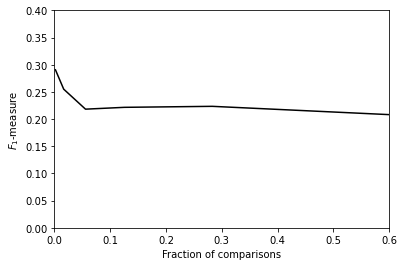

In [357]:
# plt.scatter(avg_fracofcomp, avg_f1star)
plt.plot(listavgcompsss, listf1starssss, 'k')
plt.xlim(0,0.6)
plt.ylim(0,0.4)
plt.xlabel('Fraction of comparisons')
plt.ylabel('$F_{1}$-measure')
plt.savefig('fig4.png')